In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ds202/project

Mounted at /content/drive
/content/drive/MyDrive/ds202/project


section 4(a)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Load validation predictions
val_preds = pd.read_csv('validation_predictions.csv')

print("Validation predictions loaded. Shape:", val_preds.shape)
val_preds.head()


Validation predictions loaded. Shape: (61503, 2)


,SK_ID_CURR,PREDICTION
0,396899,0.039402
1,322041,0.050435
2,220127,0.281169
3,251531,0.023263
4,345558,0.118689


In [ ]:
# Load true labels from original application_train.csv
true_labels = pd.read_csv('input/application_train.csv')[['SK_ID_CURR', 'TARGET']]

# Merge predictions with true labels
merged = val_preds.merge(true_labels, on='SK_ID_CURR', how='left')

print("Merged dataframe shape:", merged.shape)
merged.head()


Merged dataframe shape: (61503, 3)


,SK_ID_CURR,PREDICTION,TARGET
0,396899,0.039402,0
1,322041,0.050435,0
2,220127,0.281169,0
3,251531,0.023263,0
4,345558,0.118689,0


In [ ]:
merged['TARGET'].value_counts()


,count
TARGET,
0,56538
1,4965


In [ ]:
# Merge AGE into the dataframe
age_df = pd.read_csv('input/application_train.csv')[['SK_ID_CURR', 'DAYS_BIRTH']]
age_df['AGE'] = (-age_df['DAYS_BIRTH'] / 365).astype(int)

merged = merged.merge(age_df[['SK_ID_CURR', 'AGE']], on='SK_ID_CURR', how='left')

# Create age bins
merged['AGE_GROUP'] = pd.cut(merged['AGE'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '50+'])

merged[['SK_ID_CURR', 'AGE', 'AGE_GROUP']].head()


,SK_ID_CURR,AGE,AGE_GROUP
0,396899,37,30-50
1,322041,48,30-50
2,220127,66,50+
3,251531,26,<30
4,345558,47,30-50


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

auc = roc_auc_score(merged['TARGET'], merged['PREDICTION'])
print(f'Overall AUC: {auc:.4f}')

# Threshold at 0.5 for classification
pred_labels = (merged['PREDICTION'] >= 0.5).astype(int)
acc = accuracy_score(merged['TARGET'], pred_labels)
print(f'Overall Accuracy: {acc:.4f}')


Overall AUC: 0.7888
Overall Accuracy: 0.9205


In [ ]:
for group in merged['AGE_GROUP'].unique():
    subset = merged[merged['AGE_GROUP'] == group]
    auc = roc_auc_score(subset['TARGET'], subset['PREDICTION'])
    acc = accuracy_score(subset['TARGET'], (subset['PREDICTION'] >= 0.5).astype(int))
    print(f'AGE_GROUP: {group}, AUC: {auc:.4f}, Accuracy: {acc:.4f}')


AGE_GROUP: 30-50, AUC: 0.7968, Accuracy: 0.9170
AGE_GROUP: 50+, AUC: 0.7656, Accuracy: 0.9433
AGE_GROUP: <30, AUC: 0.7636, Accuracy: 0.8881


section 4(b)

In [ ]:
from sklearn.metrics import confusion_matrix

for group in merged['AGE_GROUP'].unique():
    subset = merged[merged['AGE_GROUP'] == group]
    y_true = subset['TARGET']
    y_pred = (subset['PREDICTION'] >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f'AGE_GROUP: {group}')
    print(f'  TPR: {tpr:.4f}')
    print(f'  FPR: {fpr:.4f}')


AGE_GROUP: 30-50
  TPR: 0.0494
  FPR: 0.0031
AGE_GROUP: 50+
  TPR: 0.0311
  FPR: 0.0012
AGE_GROUP: <30
  TPR: 0.0471
  FPR: 0.0041


section 4(c)

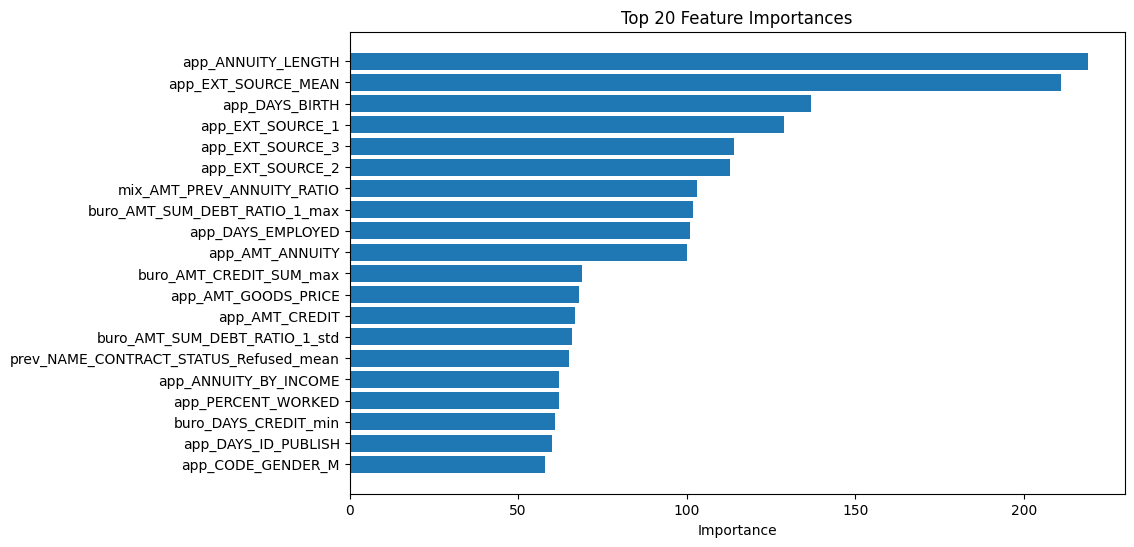

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb

model = lgb.Booster(model_file='output/model.txt')

# Get feature importances
importances = model.feature_importance()
feature_names = model.feature_name()


# Create DataFrame and sort
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()
